In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from dataclasses import dataclass
import numpy as np
import time

In [ ]:
# Returns a graph and the id of a node in the graph
def create_random_graph(n, graph_type="erdos_renyi") -> tuple[nx.Graph, int | None]:
    G: nx.Graph = None

    match graph_type:
        case "erdos_renyi":
            # Edge probability 0.3, you can adjust this as needed
            G = nx.erdos_renyi_graph(n, 0.3)
        case "newman_watts_strogatz":
            # N=number of nodes, K=neighbors, p=probability of rewiring
            G = nx.newman_watts_strogatz_graph(n, 4, 0.15)
        case "barabasi_albert":
            G = nx.barabasi_albert_graph(n, 2)
        case "watts_strogatz":
            G = nx.watts_strogatz_graph(n, 4, 0.15)
        case "random_geometric":
            G = nx.random_geometric_graph(n, 0.3)
        case _:
            raise ValueError("Invalid graph type")

    # Don't add weights to edges since we're requiring equal influence
    #
    # for _, _, edge_data in G.edges.data():
    #     # Note: these are in the interval [0, 1); is this ok?
    #     # First influence is from second to first;
    #     edge_data["influence"] = [random.random(), random.random()]

    node = None

    # Assign thresholds and influence factors
    for n, n_data in G.nodes.data():
        deg = G.degree(n)

        if deg == 0:
            G.remove_node(n)
            continue

        node = n

        inf = random.randint(1, 1000)
        n_data["inf"] = inf
        # Assume inf <= thresh <= degree * inf
        n_data["thresh"] = random.randint(inf, G.degree(n) * inf)

    return G, node

In [ ]:
# Returns a graph and the id of a node in the graph
def create_random_graph_raw(n, graph_type="erdos_renyi") -> tuple[nx.Graph, int | None]:
    G: nx.Graph = None

    match graph_type:
        case "erdos_renyi":
            # Edge probability 0.3, you can adjust this as needed
            G = nx.erdos_renyi_graph(n, 0.3)
        case "newman_watts_strogatz":
            # N=number of nodes, K=neighbors, p=probability of rewiring
            G = nx.newman_watts_strogatz_graph(n, 4, 0.15)
        case "barabasi_albert":
            G = nx.barabasi_albert_graph(n, 2)
        case "watts_strogatz":
            G = nx.watts_strogatz_graph(n, 4, 0.15)
        case "random_geometric":
            G = nx.random_geometric_graph(n, 0.3)
        case _:
            raise ValueError("Invalid graph type")


    for _, _, edge_data in G.edges.data():
        # First influence is from second to first;
        edge_data["influence"] = [random.random(), random.random()]

    node = None

    # Assign thresholds and influence factors
    for n, n_data in G.nodes.data():
        deg = G.degree(n)

        if deg == 0:
            G.remove_node(n)
            continue

        node = n

        inf = random.randint(1, 1000)
        n_data["inf"] = inf
        # Assume inf <= thresh <= degree * inf
        n_data["thresh"] = random.randint(inf, G.degree(n) * inf)

    return G, node

In [ ]:
def treeify(G: nx.Graph, r: int) -> nx.Graph:
    G_new = nx.Graph()

    queue = [r]
    visited = {r}

    while len(queue) > 0:
        n = queue[0]

        G_new.add_node(n, **G.nodes[n])

        neighbors = set(G.neighbors(n)) - visited

        G_new.add_edges_from((n, nb, G.edges[n, nb]) for nb in neighbors)

        queue.pop(0)
        queue.extend(neighbors)
        visited = visited | neighbors

    return G_new

Influences: {1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 3, 7: 9, 8: 2, 9: 3, 10: 1, 11: 2, 12: 2, 13: 4}
Thresholds: {1: 14, 2: 11, 3: 9, 4: 8, 5: 15, 6: 3, 7: 9, 8: 2, 9: 3, 10: 1, 11: 2, 12: 2, 13: 4}


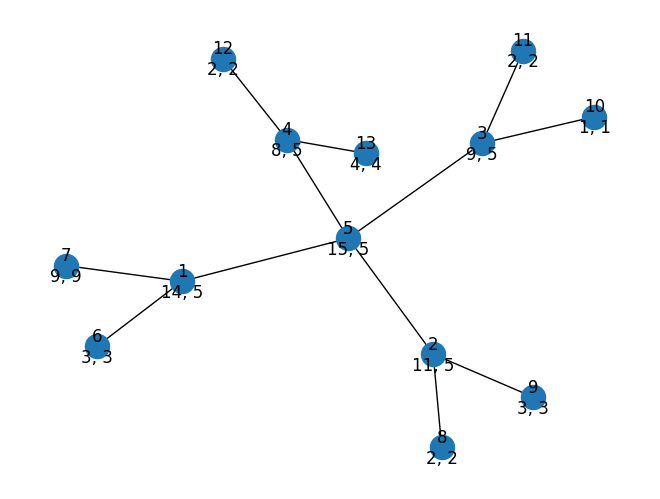

In [ ]:
# Example usage:
n = 12  # Number of nodes in the graph

# Specify the type of graph (erdos_renyi or newman_watts_strogatz)
graph_type = "erdos_renyi"
random_graph = treeify(*create_random_graph(n, graph_type))

random_graph = nx.Graph()
random_graph.add_node(1, thresh=14, inf=5)
random_graph.add_node(2, thresh=11, inf=5)
random_graph.add_node(3, thresh=9, inf=5)
random_graph.add_node(4, thresh=8, inf=5)
random_graph.add_node(5, thresh=15, inf=5)
random_graph.add_node(6, thresh=3, inf=3)
random_graph.add_node(7, thresh=9, inf=9)
random_graph.add_node(8, thresh=2, inf=2)
random_graph.add_node(9, thresh=3, inf=3)
random_graph.add_node(10, thresh=1, inf=1)
random_graph.add_node(11, thresh=2, inf=2)
random_graph.add_node(12, thresh=2, inf=2)
random_graph.add_node(13, thresh=4, inf=4)
random_graph.add_edges_from(((5, 1), (5, 2), (5, 3), (5, 4), (1, 6), (1, 7), (2, 8), (2, 9), (3, 10), (3, 11), (4, 12), (4, 13)))


# plot the graph

def fmt_data(n, x):
    return f"{n}\n{x['thresh']}, {x['inf']}"

def fmt_nodes(G):
    return {n: fmt_data(n, data) for n, data in G.nodes.data()}

nx.draw(random_graph, with_labels=True, labels=fmt_nodes(random_graph))
print("Influences:", nx.get_node_attributes(random_graph, "inf"))
print("Thresholds:", nx.get_node_attributes(random_graph, "thresh"))

In [ ]:
def propagate(G: nx.Graph, n: int, active: set[int]) -> set[int]:
    # Activate n
    n_data = G.nodes[n]
    active = active | {n}

    # Propagate
    for nb in set(G.neighbors(n)) - active:
        nb_data = G.nodes[nb]
        nb_data["thresh"] -= nb_data["inf"]

        if nb_data["thresh"] <= 0:
            active = propagate(G, nb, active)
        else:
            # Maintains assumption inf <= thresh <= degree * inf
            nb_data["inf"] = min(nb_data["inf"], nb_data["thresh"])
            nb_data["thresh"] = min(nb_data["thresh"], G.degree(nb) * nb_data["inf"])

    return active

In [ ]:
# We now describe an O(|V|log|V|) greedy algorithm.
# In each step, from among the inactive nodes, we select the node with the smallest value of di (ties can be broken arbitrarily)
# and pay it the amount of its threshold bi. Next, we carry out the propagation process from this newly activated node.
# We update the thresholds by lowering the value of bi by the amount of (incoming) influence.
# After that, all active nodes are removed from the graph.

# Will mutate G, so pass in a copy
def greedy_algo(G: nx.Graph) -> float:
    cost = 0
    pay_order = []

    G_ = nx.Graph()
    G_.add_nodes_from(sorted(G.nodes.data(), key=lambda p: p[1]["inf"]))
    G_.add_edges_from(G.edges.data())
    G = G_

    while G.number_of_nodes() > 0:
        # find the node with the smallest values of di (influence from other nodes)
        n_min, n_min_data = next(iter(G.nodes.data()))

        # print(f"n_min: {n_min}, inf: {n_min_data['inf']}, thresh: {n_min_data['thresh']}")

        # pay the node the amount of its threshold in order to make it active
        cost += n_min_data["thresh"]
        pay_order.append(n_min)

        activated = propagate(G, n_min, set())
        G.remove_nodes_from(activated)

    return cost, pay_order

In [ ]:
# This output agrees with the paper's example, except where there is a tie for n_min
cost, pay_order = greedy_algo(random_graph.copy())
print(f"Total cost: {cost}")
print(f"Pay order: {pay_order}")

Total cost: 26
Pay order: [10, 8, 11, 12, 6, 9, 13, 1]


In [ ]:
# A PartialCosts is a partial incentive table
PartialCosts = dict[int, float]

@dataclass
class INIPair:
    no_inf: PartialCosts
    with_inf: PartialCosts

# If m has type Memo, then m[c].no_inf is equivalent to the paper's p_{NI}^c
# (the vector of partial costs in the no-influence case for star centered at c)
Memo = dict[int, INIPair]

In [ ]:
def solve_star(G: nx.Graph, c: int, parent: int, with_inf: bool) -> tuple[PartialCosts, float]:
    c_data = G.nodes[c]

    if with_inf:
        c_data["thresh"] = c_data["thresh"] - c_data["inf"]
        c_data["inf"] = min(c_data["thresh"], c_data["inf"])

    # num_active_needed is the number of active nodes needed to activate c
    # need prevent division by zero
    # num_active_needed = math.ceil(c_data["thresh"] / c_data["inf"])
    num_active_needed = 1 if c_data["inf"] == 0 else math.ceil(c_data["thresh"] / c_data["inf"])

    neighbors = ((nb, G.nodes[nb]) for nb in filter(lambda nb: nb != parent, G.neighbors(c)))
    candidates = filter(lambda t: t[1]["thresh"] < c_data["inf"], neighbors)
    candidates: list[tuple[int, dict]] = sorted(candidates, key=lambda t: t[1]["thresh"])

    # The paper's p vector
    partial_costs: PartialCosts = {}

    if len(candidates) >= num_active_needed:
        # Pay only the number of candidates needed
        candidates = candidates[:num_active_needed]

        partial_costs = {cand: data["thresh"] for cand, data in candidates[:-1]}

        c_new_thresh = c_data["thresh"] - (num_active_needed - 1) * c_data["inf"]

        final_cand, final_cand_data = candidates[-1]

        if final_cand_data["thresh"] < c_new_thresh:
            partial_costs[final_cand] = final_cand_data["thresh"]
        else:
            partial_costs[c] = c_new_thresh
    else:
        # Pay all candidates and then the remainder for c
        partial_costs = {cand: data["thresh"] for cand, data in candidates}
        partial_costs[c] = c_data["thresh"] - len(candidates) * c_data["inf"]

    # The paper's set X is just partial_costs.keys()
    return partial_costs, sum(partial_costs.values())

In [ ]:
def star_handling(G: nx.Graph, m: Memo, c: int, parent: int):
    m[c] = INIPair(None, None)
    m[c].no_inf, cost_no_inf = solve_star(G, c, parent, False)

    if parent is not None:
        m[c].with_inf, cost_with_inf = solve_star(G, c, parent, True)
        G.nodes[c]["thresh"] = cost_no_inf - cost_with_inf


In [ ]:
def backtrack(G: nx.Graph, m: Memo, r: int) -> PartialCosts:
    def not_leaf(n: int):
        return G.degree(n) > 1

    def nb_set(n: int, parent: int):
        return set(G.neighbors(n)) - {parent}

    partial_costs = m[r].no_inf.copy()

    def with_influence(c: int, parent: int):
        p = m[c].with_inf

        partial_costs.pop(c, None)
        partial_costs.update(p)

        for n in filter(not_leaf, nb_set(c, parent) & p.keys()):
            no_influence(n, c)

        for n in filter(not_leaf, nb_set(c, parent) - p.keys()):
            with_influence(n, c)

    def no_influence(c: int, parent: int):
        p = m[c].no_inf

        partial_costs.pop(c, None)
        partial_costs.update(p)

        for n in filter(not_leaf, nb_set(c, parent) & p.keys()):
            no_influence(n, c)

        for n in filter(not_leaf, nb_set(c, parent) - p.keys()):
            with_influence(n, c)

    for n in filter(not_leaf, nb_set(r, None) & partial_costs.keys()):
        no_influence(n, r)

    for n in filter(not_leaf, nb_set(r, None) - partial_costs.keys()):
        with_influence(n, r)

    return partial_costs


In [ ]:
# r is treated as the root node; can be any arbitrary node in the tree
def dp_algo(G: nx.Graph, r: int):
    m: Memo = {}

    def dfs(n: int, parent: int | None):
        if parent is not None and G.degree(n) <= 1:
            return

        for child in filter(lambda n: n != parent, G.neighbors(n)):
            dfs(child, n)

        # print(f"Handling {n}")
        star_handling(G, m, n, parent)
        # print(m[n])

    dfs(r, None)

    partial_costs = backtrack(G, m, r)

    return partial_costs, sum(partial_costs.values())

In [ ]:
# Run DP algorithm

partial_costs, cost = dp_algo(random_graph.copy(), 5)
print(partial_costs)
print(f"Total cost: {cost}")

{8: 2, 9: 3, 2: 1, 10: 1, 11: 2, 12: 2, 4: 3, 6: 3, 1: 4}
Total cost: 21


In [ ]:
# Specify the type of graph (erdos_renyi or newman_watts_strogatz)
graph_type = "erdos_renyi"

ns = []
greedy_dts = []
dp_dts = []

for n in range(100, 10000, 100):
    G = treeify(*create_random_graph(n, graph_type))
    start = time.perf_counter_ns()
    greedy_algo(G.copy())
    end = time.perf_counter_ns()
    dt_greedy = end - start
    start = time.perf_counter_ns()
    dp_algo(G.copy(), 0)
    end = time.perf_counter_ns()
    dt_dp = end - start

    print(f"n: {n}, dt_greedy: {dt_greedy}, dt_dp: {dt_dp}")
    ns.append(n)
    greedy_dts.append(dt_greedy)
    dp_dts.append(dt_dp)


n: 100, dt_greedy: 1423750, dt_dp: 1076833
n: 200, dt_greedy: 2077584, dt_dp: 1136250
n: 300, dt_greedy: 1961584, dt_dp: 1273917
n: 400, dt_greedy: 2211208, dt_dp: 1311584
n: 500, dt_greedy: 2502875, dt_dp: 1522125
n: 600, dt_greedy: 3267708, dt_dp: 1869666
n: 700, dt_greedy: 4124000, dt_dp: 2180916
n: 800, dt_greedy: 4219250, dt_dp: 2351750
n: 900, dt_greedy: 5094792, dt_dp: 2775208
n: 1000, dt_greedy: 5409416, dt_dp: 2980750
n: 1100, dt_greedy: 5727708, dt_dp: 3225167
n: 1200, dt_greedy: 6442542, dt_dp: 3448292
n: 1300, dt_greedy: 6886416, dt_dp: 3799375
n: 1400, dt_greedy: 7458833, dt_dp: 4179291
n: 1500, dt_greedy: 7920125, dt_dp: 4385083
n: 1600, dt_greedy: 8435584, dt_dp: 4942541
n: 1700, dt_greedy: 8726042, dt_dp: 4835250
n: 1800, dt_greedy: 9355334, dt_dp: 5145000
n: 1900, dt_greedy: 9686209, dt_dp: 5415083
n: 2000, dt_greedy: 10303834, dt_dp: 5649458
n: 2100, dt_greedy: 11781583, dt_dp: 6061458
n: 2200, dt_greedy: 12041958, dt_dp: 6375792
n: 2300, dt_greedy: 12346875, dt_dp: 6

In [ ]:
print(sorted(greedy_dts)[:10])

[2597375, 2823917, 3013042, 3199917, 4006333, 4824542, 5787834, 6901083, 7224833, 8764792]


c = -114475.4087944445, k = 3067.34136685602


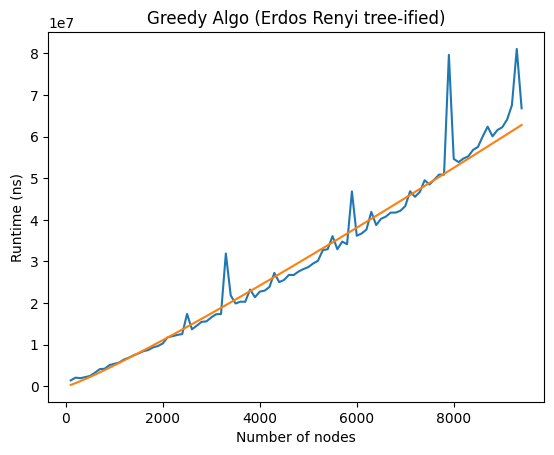

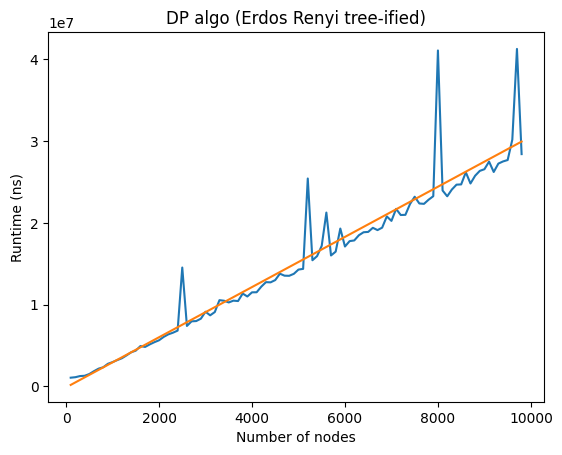

In [ ]:
ns = np.array(ns)

# remove greedy outliers

greedy_ns, greedy_dts = zip(*filter(lambda p: p[1] < 3e8, zip(ns, greedy_dts)))

plt.figure()
plt.plot(greedy_ns, greedy_dts)
plt.plot(greedy_ns, 730*np.multiply(greedy_ns, np.log(greedy_ns)))
plt.xlabel("Number of nodes")
plt.ylabel("Runtime (ns)")
plt.title("Greedy Algo (Erdos Renyi tree-ified)")

plt.figure()

# Remove outliers
dp_ns, dp_dts = zip(*filter(lambda p: p[1] < 2e8, zip(ns, dp_dts)))
dp_ns = np.array(dp_ns)
dp_dts = np.array(dp_dts)

k, c = np.polyfit(dp_ns, dp_dts, 1)

print(f"c = {c}, k = {k}")

plt.plot(dp_ns, dp_dts)
plt.plot(dp_ns, c + k * dp_ns)
plt.xlabel("Number of nodes")
plt.ylabel("Runtime (ns)")
plt.title("DP algo (Erdos Renyi tree-ified)")

plt.show()

In [ ]:
from tqdm import tqdm
# Specify the type of graph (erdos_renyi or newman_watts_strogatz)
graph_type = "barabasi_albert"

ns_ba = []
greedy_dts_ba = []
dp_dts_ba = []

for n in tqdm(range(100, 15000, 100)):
    G = treeify(*create_random_graph(n, graph_type))
    start = time.perf_counter_ns()
    greedy_algo(G.copy())
    end = time.perf_counter_ns()
    dt_greedy = end - start
    start = time.perf_counter_ns()
    dp_algo(G.copy(), 0)
    end = time.perf_counter_ns()
    dt_dp = end - start

    # print(f"n: {n}, dt_greedy: {dt_greedy}, dt_dp: {dt_dp}")
    ns_ba.append(n)
    greedy_dts_ba.append(dt_greedy)
    dp_dts_ba.append(dt_dp)

100%|██████████| 149/149 [01:08<00:00,  2.18it/s]


137 (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
137 (1138875, 2054292, 2499500, 3119084, 3281792, 3870166, 4573583, 4990083, 9681125, 6333292)
137 [4.60517019 5.29831737 5.70378247 5.99146455 6.2146081  6.39692966
 6.55108034 6.68461173 6.80239476 6.90775528]
c = 1610728.9157041549, k = 5058.465659660091


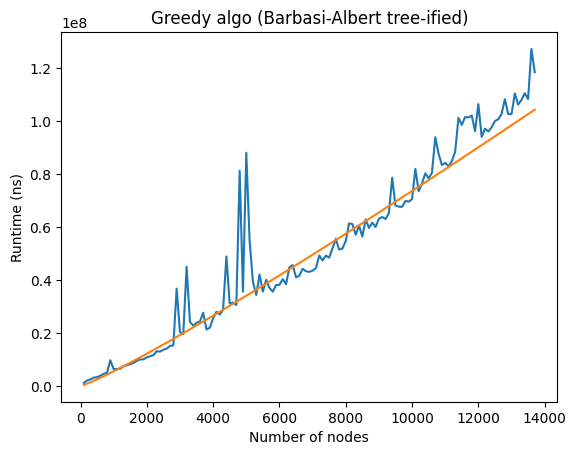

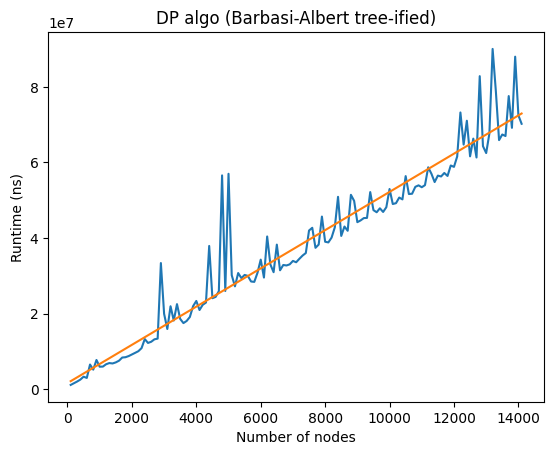

In [ ]:
ns_ba = np.array(ns_ba)

greedy_ns_ba, greedy_dts_ba = zip(
    *filter(lambda p: p[1] < 2e8, zip(ns_ba, greedy_dts_ba))
)

print(len(greedy_ns_ba), greedy_ns_ba[:10])
print(len(greedy_dts_ba), greedy_dts_ba[:10])
print(len(np.log(greedy_ns_ba)), np.log(greedy_ns_ba)[:10])

plt.figure()
plt.plot(greedy_ns_ba, greedy_dts_ba)
plt.plot(greedy_ns_ba, 770 * np.multiply(greedy_ns_ba, np.log(greedy_ns_ba) / np.log(2.62)))

plt.xlabel("Number of nodes")
plt.ylabel("Runtime (ns)")
plt.title("Greedy algo (Barbasi-Albert tree-ified)")

plt.figure()

# Remove outliers
dp_ns_ba, dp_dts_ba = zip(*filter(lambda p: p[1] < 2e8, zip(ns_ba, dp_dts_ba)))
dp_ns_ba = np.array(dp_ns_ba)
dp_dts_ba = np.array(dp_dts_ba)

k, c = np.polyfit(dp_ns_ba, dp_dts_ba, 1)

print(f"c = {c}, k = {k}")

plt.plot(dp_ns_ba, dp_dts_ba)
plt.plot(dp_ns_ba, c + k * dp_ns_ba)
plt.xlabel("Number of nodes")
plt.ylabel("Runtime (ns)")
plt.title("DP algo (Barbasi-Albert tree-ified)")

plt.show()

In [ ]:
# Specify the type of graph (erdos_renyi or newman_watts_strogatz)
graph_type = "barabasi_albert"

ns_ba = []
greedy_dts_ba = []
dp_dts_ba = []

for n in range(100, 10000, 100):
    G = treeify(*create_random_graph(n, graph_type))
    start = time.perf_counter_ns()
    greedy_algo(G.copy())
    end = time.perf_counter_ns()
    dt_greedy = end - start
    start = time.perf_counter_ns()
    dp_algo(G.copy(), 0)
    end = time.perf_counter_ns()
    dt_dp = end - start

    print(f"n: {n}, dt_greedy: {dt_greedy}, dt_dp: {dt_dp}")
    ns_ba.append(n)
    greedy_dts_ba.append(dt_greedy)
    dp_dts_ba.append(dt_dp)

n: 100, dt_greedy: 1565291, dt_dp: 2824791
n: 200, dt_greedy: 1786250, dt_dp: 1718000
n: 300, dt_greedy: 2502959, dt_dp: 2856292
n: 400, dt_greedy: 3103833, dt_dp: 3148125
n: 500, dt_greedy: 3145458, dt_dp: 3054500
n: 600, dt_greedy: 3607542, dt_dp: 3139708
n: 700, dt_greedy: 3933875, dt_dp: 4389666
n: 800, dt_greedy: 4934417, dt_dp: 3992541
n: 900, dt_greedy: 4876792, dt_dp: 4542958
n: 1000, dt_greedy: 5169000, dt_dp: 4761375
n: 1100, dt_greedy: 6027000, dt_dp: 6558333
n: 1200, dt_greedy: 6580875, dt_dp: 5549750
n: 1300, dt_greedy: 6953375, dt_dp: 6266958
n: 1400, dt_greedy: 322720708, dt_dp: 6814583
n: 1500, dt_greedy: 9306333, dt_dp: 8840500
n: 1600, dt_greedy: 9518458, dt_dp: 9180750
n: 1700, dt_greedy: 13570791, dt_dp: 14188000
n: 1800, dt_greedy: 12364958, dt_dp: 12288541
n: 1900, dt_greedy: 12019958, dt_dp: 9032583
n: 2000, dt_greedy: 10692000, dt_dp: 11099250
n: 2100, dt_greedy: 11402916, dt_dp: 10996792
n: 2200, dt_greedy: 11663292, dt_dp: 11965833
n: 2300, dt_greedy: 12357750

n: 20, dt_dp: 479750
n: 10000, dt_greedy: 591375
Original graph total cost: 2268
Original graph pay order: [12, 5, 8, 9, 13, 4, 7]
Treeified graph total cost: 10646
Treeified graph pay order: [12, 5, 8, 9, 13, 11, 4, 18, 6, 7, 17, 3, 0, 15, 1, 16, 14]


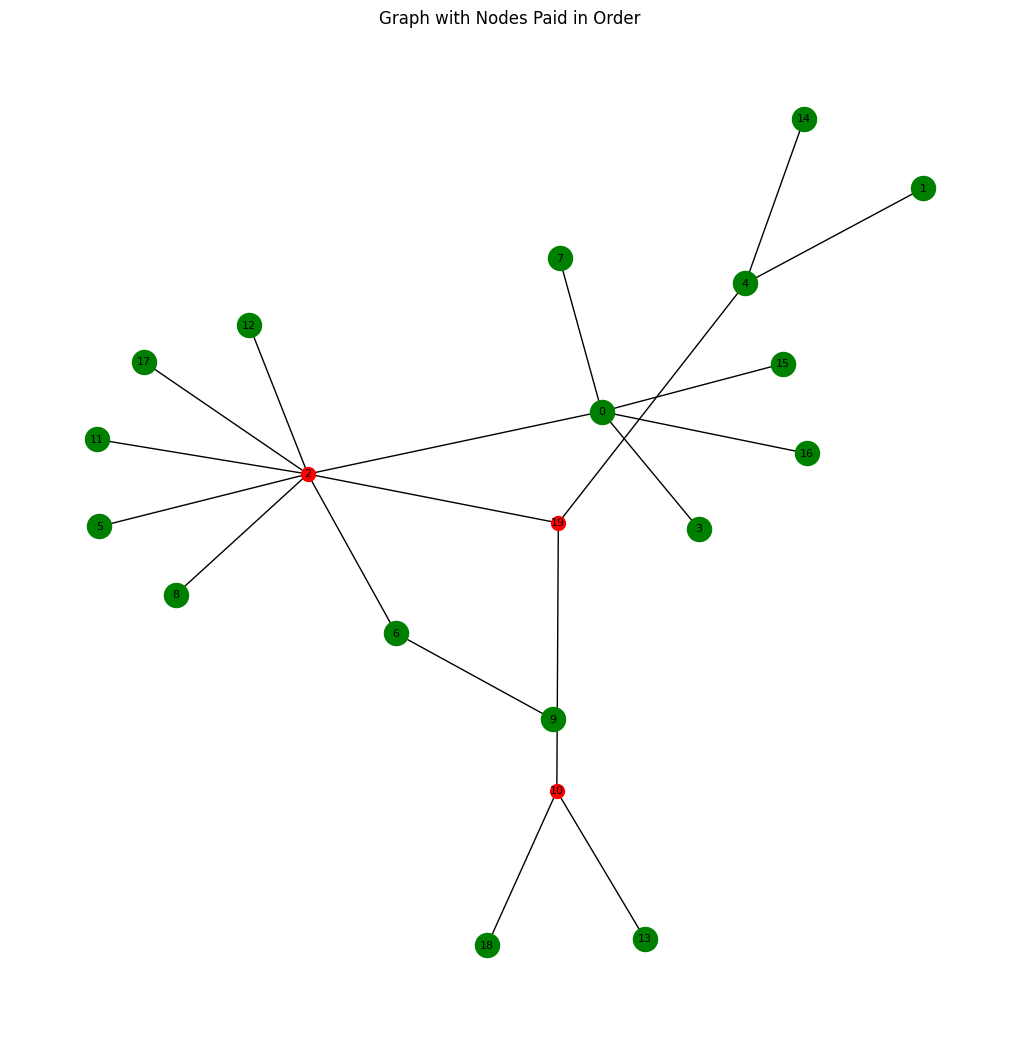

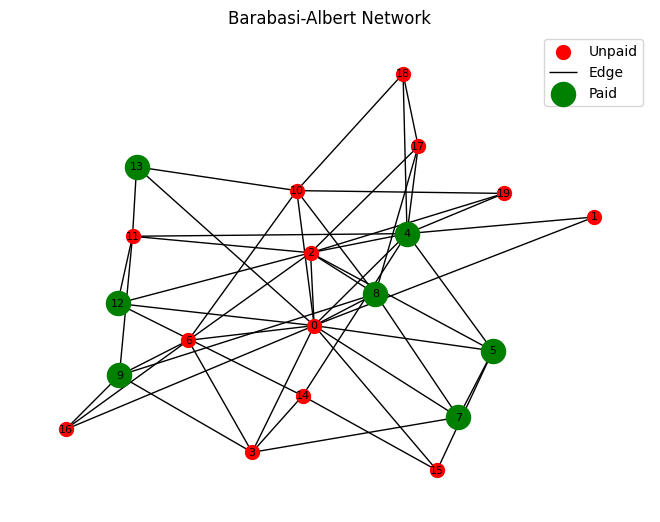

<Figure size 640x480 with 0 Axes>

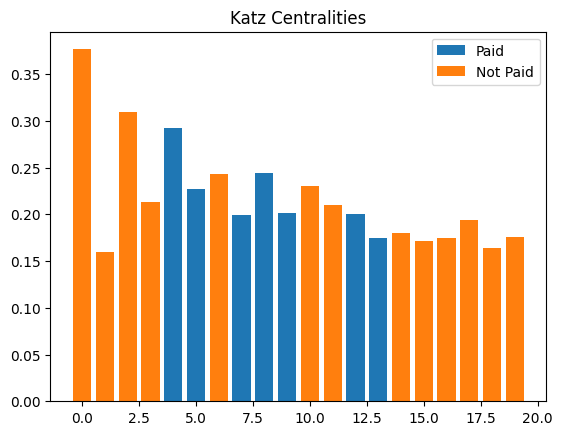

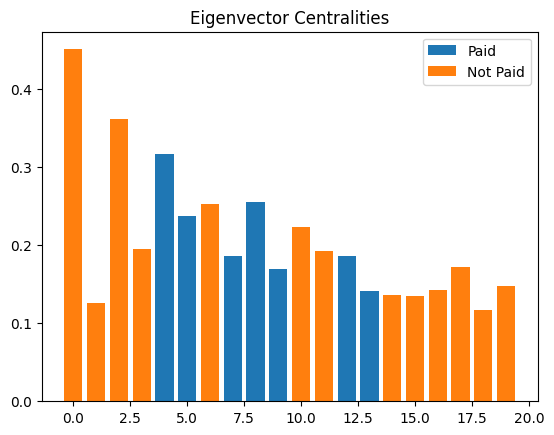

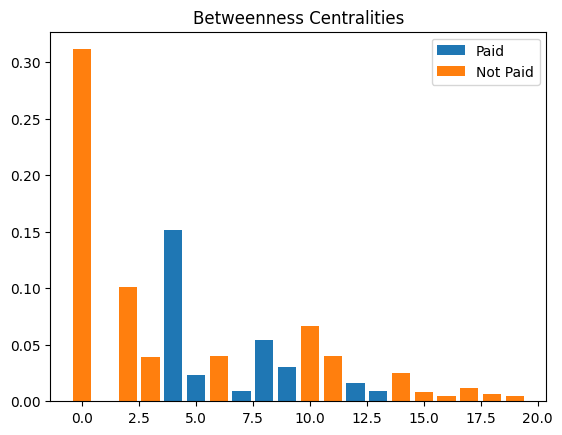

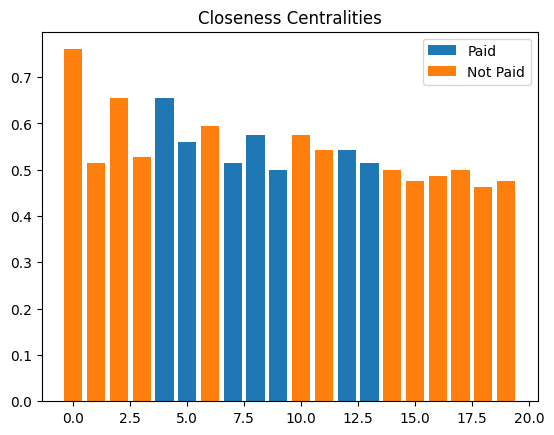

In [ ]:
# example DP for large BA graph
graph_type = "barabasi_albert"

G_orig, node = create_random_graph(20, graph_type)

G = treeify(G_orig, node)
start = time.perf_counter_ns()
dp_algo(G.copy(), 0)
end = time.perf_counter_ns()

print(f"n: 20, dt_dp: {end - start}")

# # show original network
# nx.draw(G_orig, node_size=5, width=0.5, node_color="red")
# plt.show()

# # show network. Since it has a lot of nodes, reduce node size and spread out the graph
# nx.draw(G, node_size=5, width=0.5, node_color="red")
# plt.show()

# run greedy on the original graph
start = time.perf_counter_ns()
greedy_algo(G_orig.copy())
end = time.perf_counter_ns()

print(f"n: 10000, dt_greedy: {end - start}")

# print results for original and treeified graph greedy
orig_cost, orig_pay_order = greedy_algo(G_orig.copy())
cost, pay_order = greedy_algo(G.copy())
print(f"Original graph total cost: {orig_cost}")
print(f"Original graph pay order: {orig_pay_order}")
print(f"Treeified graph total cost: {cost}")
print(f"Treeified graph pay order: {pay_order}")

# highlight the nodes in the pay order
# nx.draw(G, node_size=5, width=0.5, node_color="red")
# pos = nx.spring_layout(G)  # Use a layout method suitable for your graph
# nx.draw_networkx_nodes(G, pos, nodelist=pay_order, node_color="blue", node_size=5)
# nx.draw_networkx_nodes(G, pos, nodelist=orig_pay_order, node_color="green", node_size=5)

# Highlight the nodes in the pay order
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Specify node positions using a layout algorithm
nx.draw(G, pos, node_size=100, node_color="red")
nx.draw_networkx_nodes(
    G, pos=pos, nodelist=pay_order, node_color="green", node_size=300
)  # Highlight paid nodes
nx.draw_networkx_labels(G, pos=pos, font_size=8)  # Add labels to nodes
plt.title("Graph with Nodes Paid in Order")
plt.show()

# Highlight the nodes in the pay order
plt.figure()
pos = nx.spring_layout(G_orig)  # Specify node positions using a layout algorithm
nx.draw(G_orig, pos, node_size=100, node_color="red")
nx.draw_networkx_nodes(
    G_orig, pos=pos, nodelist=orig_pay_order, node_color="green", node_size=300
)  # Highlight paid nodes
nx.draw_networkx_labels(G_orig, pos=pos, font_size=8)  # Add labels to nodes
plt.title("Barabasi-Albert Network")
plt.legend(["Unpaid", "Edge", "Paid"])
plt.show()

# graph the katz centralities nodes, with the paid nodes being a different color
plt.figure()
katz = nx.katz_centrality(G_orig, weight="influence")
katz = {k: v for k, v in sorted(katz.items(), key=lambda item: item[1], reverse=True)}
katz_paid = {k: v for k, v in katz.items() if k in orig_pay_order}
katz_not_paid = {k: v for k, v in katz.items() if k not in orig_pay_order}
plt.figure()
plt.bar(katz_paid.keys(), katz_paid.values())
plt.bar(katz_not_paid.keys(), katz_not_paid.values())
plt.legend(["Paid", "Not Paid"])
plt.title("Katz Centralities")
plt.show()

# graph the eigenvector centralities nodes, with the paid nodes being a different color
eigenvector = nx.eigenvector_centrality(G_orig, weight="influence")
eigenvector = {k: v for k, v in sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)}
eigenvector_paid = {k: v for k, v in eigenvector.items() if k in orig_pay_order}
eigenvector_not_paid = {k: v for k, v in eigenvector.items() if k not in orig_pay_order}
plt.figure()
plt.bar(eigenvector_paid.keys(), eigenvector_paid.values())
plt.bar(eigenvector_not_paid.keys(), eigenvector_not_paid.values())
plt.legend(["Paid", "Not Paid"])
plt.title("Eigenvector Centralities")
plt.show()

# graph the betweenness centralities nodes, with the paid nodes being a different color
betweenness = nx.betweenness_centrality(G_orig, weight="influence")
betweenness = {k: v for k, v in sorted(betweenness.items(), key=lambda item: item[1], reverse=True)}
betweenness_paid = {k: v for k, v in betweenness.items() if k in orig_pay_order}
betweenness_not_paid = {k: v for k, v in betweenness.items() if k not in orig_pay_order}
plt.figure()
plt.bar(betweenness_paid.keys(), betweenness_paid.values())
plt.bar(betweenness_not_paid.keys(), betweenness_not_paid.values())
plt.legend(["Paid", "Not Paid"])
plt.title("Betweenness Centralities")
plt.show()

# graph the closeness centralities nodes, with the paid nodes being a different color
closeness = nx.closeness_centrality(G_orig)
closeness = {k: v for k, v in sorted(closeness.items(), key=lambda item: item[1], reverse=True)}
closeness_paid = {k: v for k, v in closeness.items() if k in orig_pay_order}
closeness_not_paid = {k: v for k, v in closeness.items() if k not in orig_pay_order}
plt.figure()
plt.bar(closeness_paid.keys(), closeness_paid.values())
plt.bar(closeness_not_paid.keys(), closeness_not_paid.values())
plt.legend(["Paid", "Not Paid"])
plt.title("Closeness Centralities")
plt.show()

Text(0.5, 1.0, 'Paid Katz Centralities')

<Figure size 1000x1000 with 0 Axes>

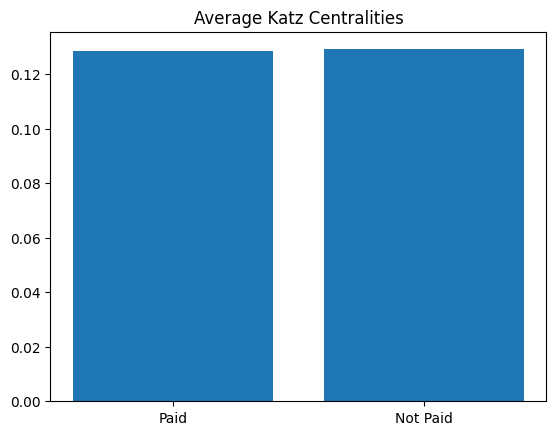

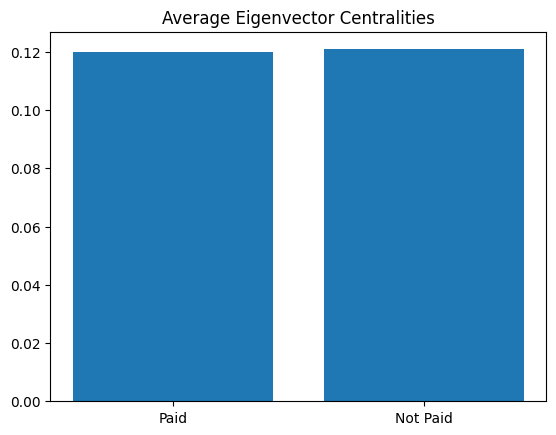

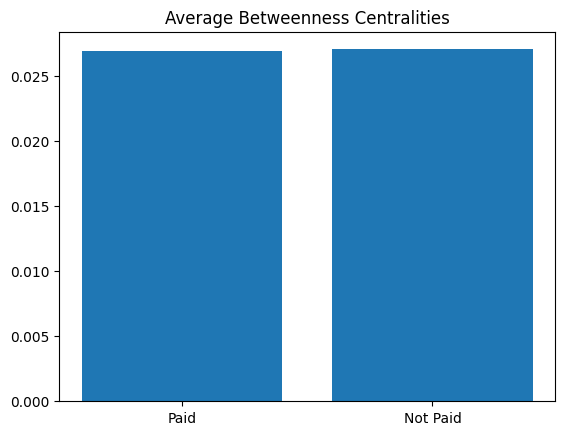

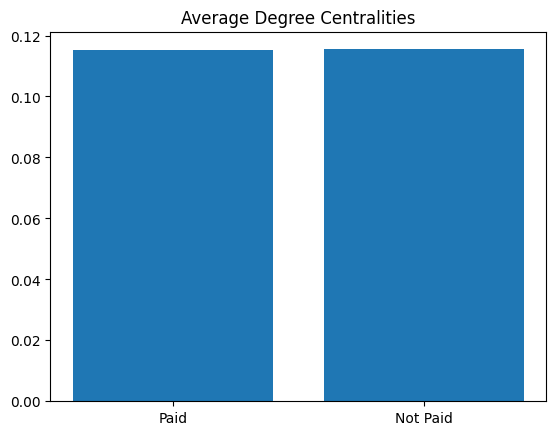

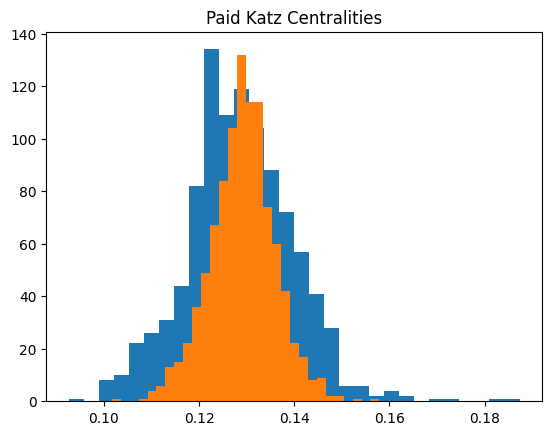

In [ ]:
# run a simulation 100x for the average paid centralities vs not paid for each centrality
avgs_paid = {"katz": [], "eigenvector": [], "betweenness": [], "degree": []}
avgs_not_paid = {"katz": [], "eigenvector": [], "betweenness": [], "degree": []}
for _ in range(1000):
    G_orig, node = create_random_graph(50, graph_type)
    orig_cost, orig_pay_order = greedy_algo(G_orig.copy())
    katz = nx.katz_centrality(G_orig, weight="influence")
    katz = {
        k: v for k, v in sorted(katz.items(), key=lambda item: item[1], reverse=True)
    }
    katz_paid = {k: v for k, v in katz.items() if k in orig_pay_order}
    katz_not_paid = {k: v for k, v in katz.items() if k not in orig_pay_order}
    avgs_paid["katz"].append(sum(katz_paid.values()) / len(katz_paid))
    avgs_not_paid["katz"].append(sum(katz_not_paid.values()) / len(katz_not_paid))

    eigenvector = nx.eigenvector_centrality(G_orig, weight="influence")
    eigenvector = {
        k: v
        for k, v in sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)
    }
    eigenvector_paid = {k: v for k, v in eigenvector.items() if k in orig_pay_order}
    eigenvector_not_paid = {
        k: v for k, v in eigenvector.items() if k not in orig_pay_order
    }
    avgs_paid["eigenvector"].append(
        sum(eigenvector_paid.values()) / len(eigenvector_paid)
    )
    avgs_not_paid["eigenvector"].append(
        sum(eigenvector_not_paid.values()) / len(eigenvector_not_paid)
    )

    betweenness = nx.betweenness_centrality(G_orig, weight="influence")
    betweenness = {
        k: v
        for k, v in sorted(betweenness.items(), key=lambda item: item[1], reverse=True)
    }
    betweenness_paid = {k: v for k, v in betweenness.items() if k in orig_pay_order}
    betweenness_not_paid = {
        k: v for k, v in betweenness.items() if k not in orig_pay_order
    }
    avgs_paid["betweenness"].append(
        sum(betweenness_paid.values()) / len(betweenness_paid)
    )
    avgs_not_paid["betweenness"].append(
        sum(betweenness_not_paid.values()) / len(betweenness_not_paid)
    )

    degree = nx.degree_centrality(G_orig)
    degree = {
        k: v for k, v in sorted(degree.items(), key=lambda item: item[1], reverse=True)
    }
    degree_paid = {k: v for k, v in degree.items() if k in orig_pay_order}
    degree_not_paid = {k: v for k, v in degree.items() if k not in orig_pay_order}
    avgs_paid["degree"].append(sum(degree_paid.values()) / len(degree_paid))
    avgs_not_paid["degree"].append(sum(degree_not_paid.values()) / len(degree_not_paid))


# graph the average paid centralities vs not paid for each centrality
plt.figure(figsize=(10, 10))
# katz
plt.figure()
plt.bar(
    ["Paid", "Not Paid"],
    [sum(avgs_paid["katz"]) / len(avgs_paid["katz"]), sum(avgs_not_paid["katz"]) / len(avgs_not_paid["katz"])],
)
plt.title("Average Katz Centralities")

# eigenvector
plt.figure()
plt.bar(
    ["Paid", "Not Paid"],
    [
        sum(avgs_paid["eigenvector"]) / len(avgs_paid["eigenvector"]),
        sum(avgs_not_paid["eigenvector"]) / len(avgs_not_paid["eigenvector"]),
    ],
)
plt.title("Average Eigenvector Centralities")

# betweenness
plt.figure()
plt.bar(
    ["Paid", "Not Paid"],
    [
        sum(avgs_paid["betweenness"]) / len(avgs_paid["betweenness"]),
        sum(avgs_not_paid["betweenness"]) / len(avgs_not_paid["betweenness"]),
    ],
)
plt.title("Average Betweenness Centralities")

# degree
plt.figure()
plt.bar(
    ["Paid", "Not Paid"],
    [sum(avgs_paid["degree"]) / len(avgs_paid["degree"]), sum(avgs_not_paid["degree"]) / len(avgs_not_paid["degree"])],
)
plt.title("Average Degree Centralities")


# make histograms of the paid and not paid centralities
plt.figure()
plt.hist(avgs_paid["katz"], bins=30)
plt.hist(avgs_not_paid["katz"], bins=30)
plt.title("Paid Katz Centralities")

In [ ]:
# propagate for one time step
def propagate_timestep(G: nx.Graph, active: set[int]) -> set[int]:
    # Propagate
    new_active = set()
    for active_node in active:
        for neighbor in G.neighbors(active_node):
            if neighbor not in active:
                neighbor_data = G.nodes[neighbor]
                curr_thresh = neighbor_data["thresh"] - sum(
                    [
                        neighbor_data["inf"]
                        for neighbor_neighbor in G.neighbors(neighbor)
                        if neighbor_neighbor in active
                    ]
                )

                if curr_thresh <= 0:
                    new_active.add(neighbor)
                # else:
                #     # Maintains assumption inf <= thresh <= degree * inf
                #     neighbor_data["inf"] = min(neighbor_data["inf"], neighbor_data["thresh"])
                #     neighbor_data["thresh"] = min(
                #         neighbor_data["thresh"], G.degree(neighbor) * neighbor_data["inf"]
                #     )

        # remove active node from the graph
        # G.remove_node(active_node)
    return new_active

In [ ]:
# demo the progression of influence for a graph given manually chosen paid nodes
G, node = create_random_graph(15, graph_type)

# experimental copy
G_exp = G.copy()

# create a copy for the greedy algo
G_greedy = G.copy()

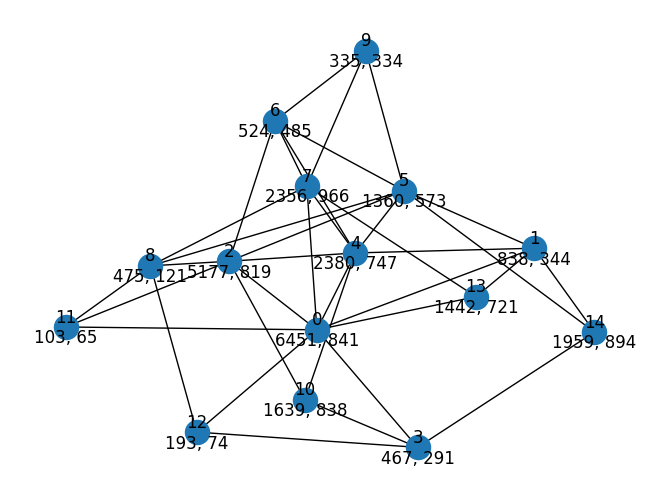

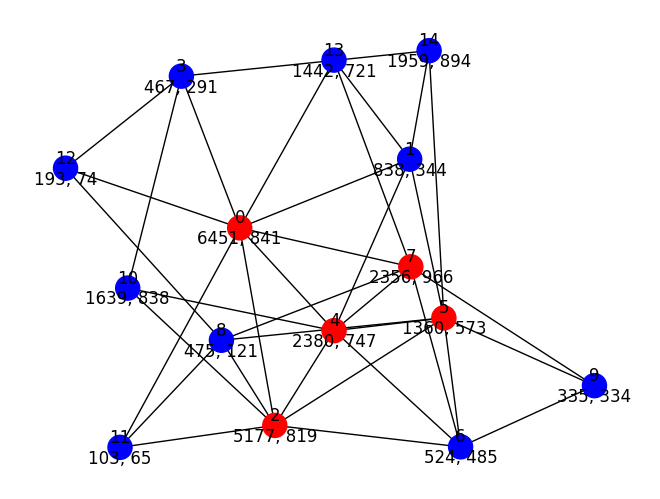

post t: 0, active: {0, 2, 4, 5, 7}


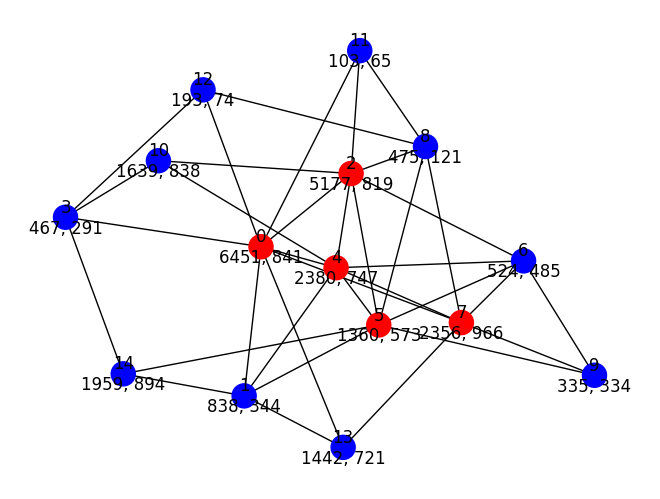

post t: 1, active: {0, 2, 4, 5, 7}, just_activated: {1, 6, 9, 10, 11, 13}


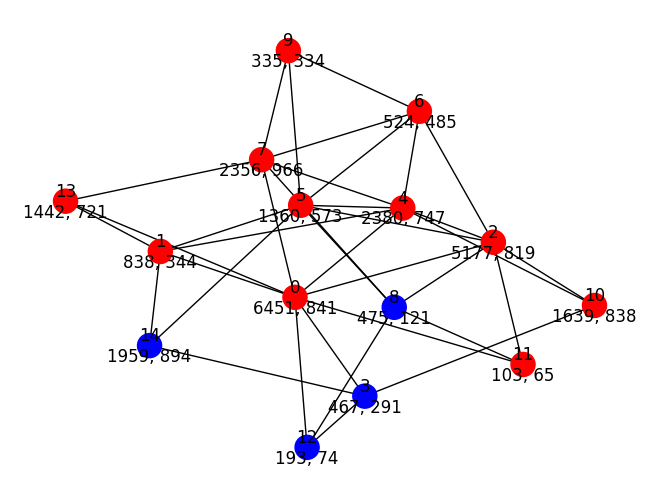

post t: 2, active: {0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 13}, just_activated: {8, 3}


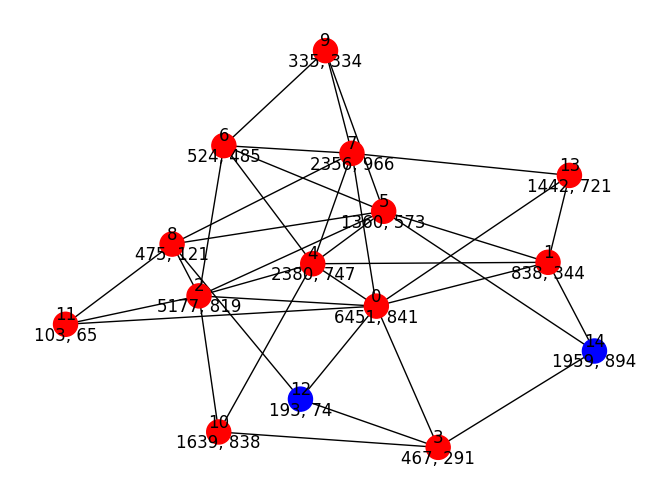

post t: 3, active: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13}, just_activated: {12, 14}


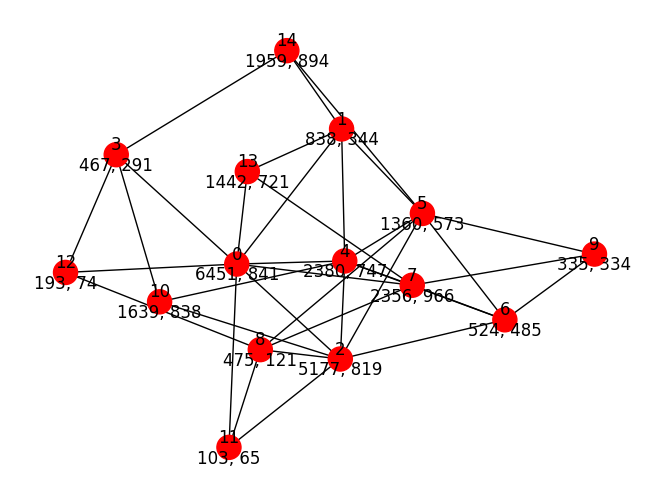

post t: 4, active: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}, just_activated: set()
originally paid [4, 2, 0, 5, 7] thresholds [2380, 5177, 6451, 1360, 2356]
Centrality based Total cost: 17724
Greedy Total cost: 2141
Pay order: [11, 12, 8, 3, 9, 1, 2]


Text(0.5, 1.0, 'Original Graph with Nodes Paid in Order')

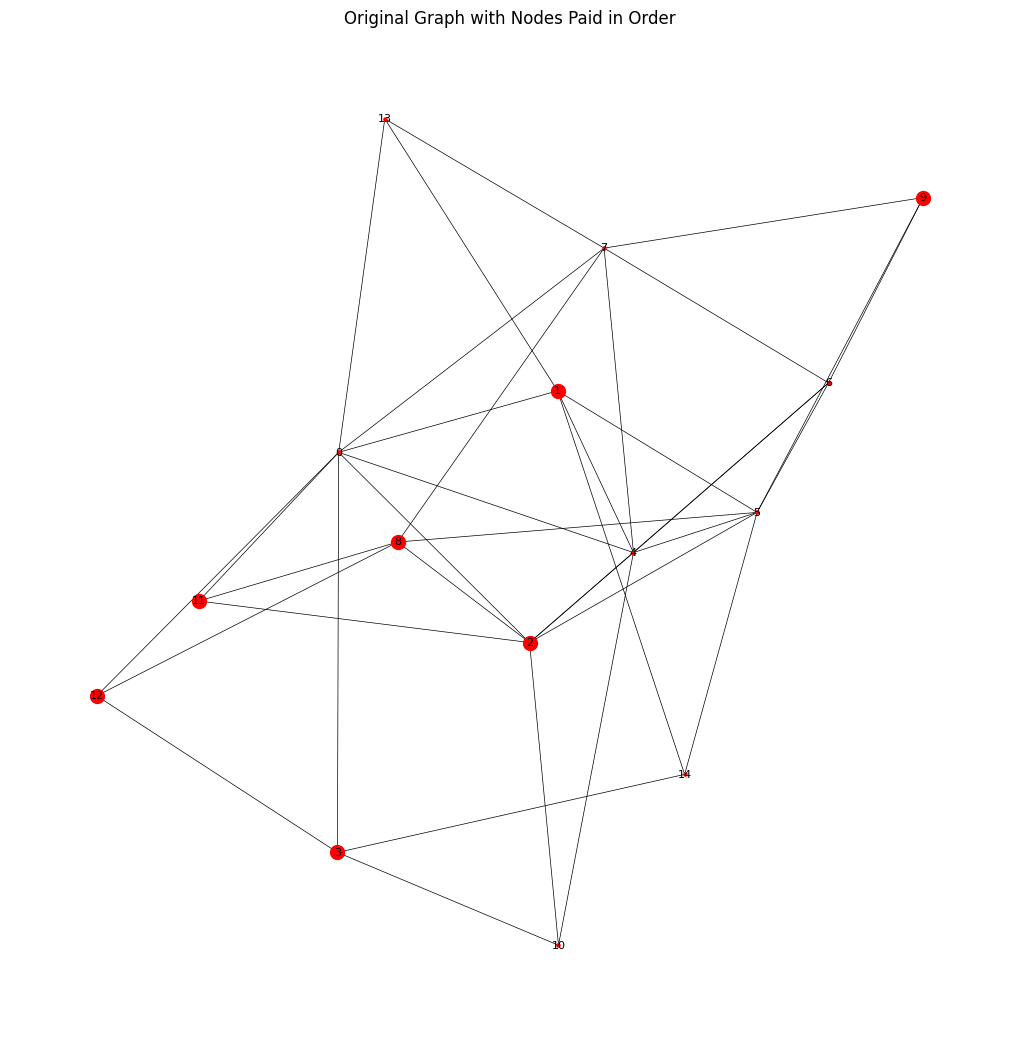

In [ ]:
# # demo the progression of influence for a graph given manually chosen paid nodes
# G, node = create_random_graph(15, graph_type)

# # create a copy for the greedy algo
# G_greedy = G.copy()

# show the graph with numbers
nx.draw(G, with_labels=True, labels=fmt_nodes(G))
plt.show()

# manually chosen paid nodes
# paid_nodes = [7]
# paid_nodes = [2, 5, 11, 4, 3, 13, 0, 8, 10]

# # select paid nodes based on eigenvalue centrality
# eigenvector = nx.eigenvector_centrality(G, weight="inf")
# eigenvector = {k: v for k, v in sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)}
# paid_nodes = list(eigenvector.keys())[:5]

# select paid nodes based on degree centrality
eigenvector = nx.degree_centrality(G, weight="inf")
eigenvector = {
    k: v for k, v in sorted(eigenvector.items(), key=lambda item: item[1], reverse=True)
}
paid_nodes = list(eigenvector.keys())[:5]

just_activated = set(paid_nodes)
active = set(paid_nodes)
cost = sum(G.nodes[n]["thresh"] for n in paid_nodes)

# show how the activation progresses
t = 0
nx.draw(
    G,
    with_labels=True,
    labels=fmt_nodes(G),
    node_color=["red" if n in active else "blue" for n in G.nodes()],
)
plt.show()
print(f"post t: {t}, active: {active}")
while(True):
    t += 1
    # just activated nodes should exert influence only once
    active = active | just_activated
    just_activated = propagate_timestep(G, active)
    nx.draw(
        G,
        with_labels=True,
        labels=fmt_nodes(G),
        node_color=["red" if n in active else "blue" for n in G.nodes()],
    )
    plt.show()
    print(f"post t: {t}, active: {active}, just_activated: {just_activated}")
    if len(just_activated) == 0:
        break

print("originally paid", paid_nodes, "thresholds", [G.nodes[n]["thresh"] for n in paid_nodes])
print(f"Centrality based Total cost: {cost}")


# compare to greedy solution:
cost, g_pay_order = greedy_algo(G_greedy.copy())
print(f"Greedy Total cost: {cost}")
print(f"Pay order: {g_pay_order}")

# show the graph with the greedy pay order
# Highlight the nodes in the pay order
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_greedy)  # Specify node positions using a layout algorithm
nx.draw(G_greedy, pos, node_size=5, width=0.5, node_color="red")
nx.draw_networkx_nodes(
    G_greedy, pos=pos, nodelist=g_pay_order, node_color="red", node_size=100
)  # Highlight paid nodes
nx.draw_networkx_labels(G_greedy, pos=pos, font_size=8)  # Add labels to nodes
plt.title("Original Graph with Nodes Paid in Order")

In [ ]:
social_path = "/Users/Michael/Downloads/socfb-American75/socfb-American75.mtx"

# read the file as a space separated file
with open(social_path, "r") as file:
    lines = file.readlines()

# remove the first two lines
lines = lines[2:]
edges = {}
for line in lines:
    # split the line into two nodes
    node1, node2 = line.split(" ")
    node1 = int(node1)
    node2 = int(node2)
    # add the nodes to the edges dictionary
    if node1 in edges:
        edges[node1].append(node2)
    else:
        edges[node1] = [node2]

    if node2 in edges:
        edges[node2].append(node1)
    else:
        edges[node2] = [node1]

# remove edges with only one connection
edges = {k: v for k, v in edges.items() if len(v) > 1}

dt_greedy: 1506280125
Total cost: 25299
Pay order: [315, 5525, 2955, 1183, 3210, 1256, 2624, 4179, 1537, 5199, 1823, 4947, 3368, 4791, 3949, 4604, 1172, 4939, 893, 4613, 3190, 4184, 743, 5561, 5545, 2411, 5137, 366, 1433, 2250, 786, 4679, 4805, 1224, 6193, 885, 2454, 5765, 6167, 772, 3185, 1720, 5110, 6010, 798, 1355, 3501, 4585, 4804, 2734, 801, 203, 3991, 587, 2690, 1937, 6140, 4870, 4892, 3409, 5997, 2083, 714, 1988, 5405, 844, 6377, 905, 1196, 4132, 5671, 4277, 3088, 1167, 701, 1778, 1456, 3920, 3346, 3696, 4753, 1616, 4953]


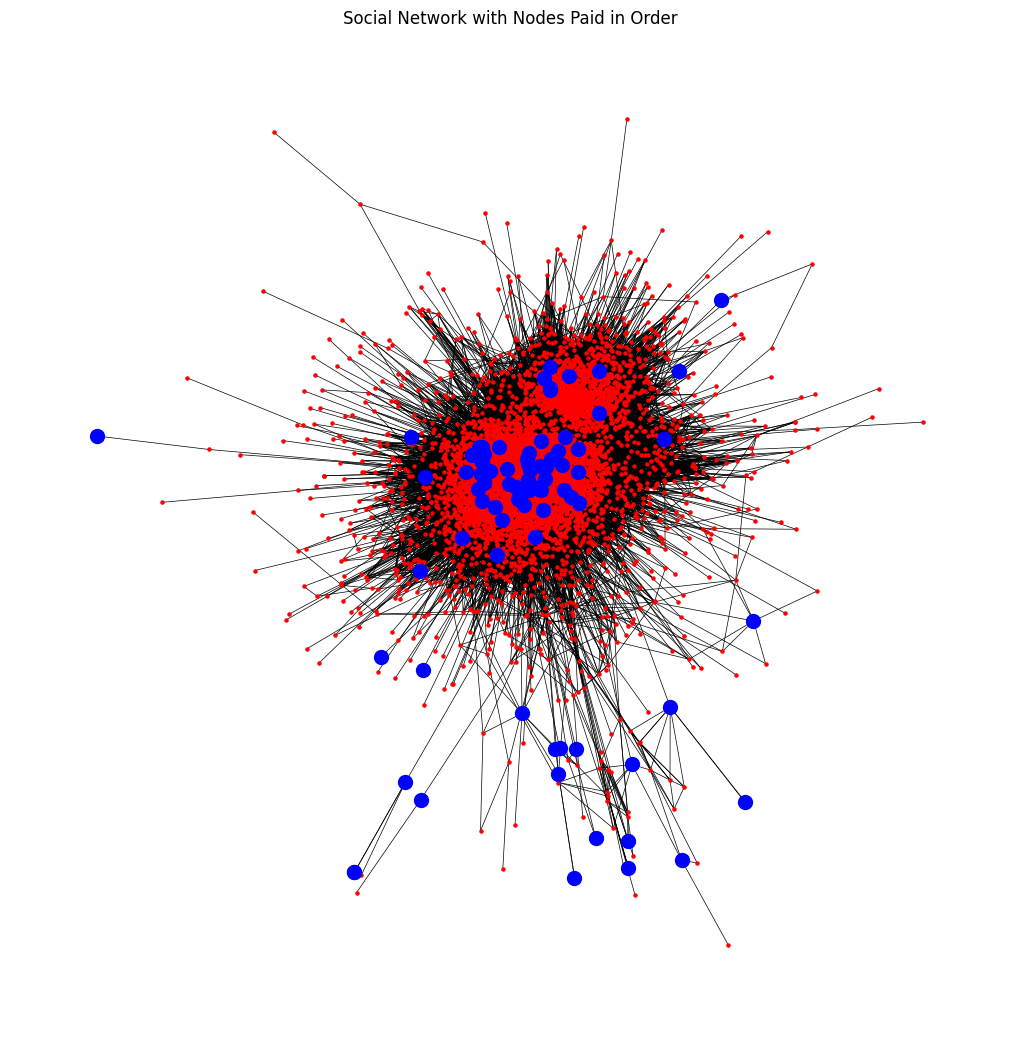

In [ ]:
# create a graph from the edges
G_social = nx.Graph(edges)

# add arbitrary influence and threshold values
for n, n_data in G_social.nodes.data():
    n_data["inf"] = random.randint(1, 1000)
    n_data["thresh"] = random.randint(n_data["inf"], G_social.degree(n) * n_data["inf"])

# show the graph
# nx.draw(G_social, node_size=5, width=0.5, node_color="red")
# plt.show()

# run the greedy algo on the social graph
start = time.perf_counter_ns()
cost, pay_order = greedy_algo(G_social.copy())
end = time.perf_counter_ns()
print(f"dt_greedy: {end - start}")
print(f"Total cost: {cost}")
print(f"Pay order: {pay_order}")

# Highlight the nodes in the pay order
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_social)  # Specify node positions using a layout algorithm
nx.draw(G_social, pos, node_size=5, width=0.5, node_color="red")
nx.draw_networkx_nodes(
    G_social, pos=pos, nodelist=pay_order, node_color="blue", node_size=100
)  # Highlight paid nodes
# nx.draw_networkx_labels(G_social, pos=pos, font_size=8)  # Add labels to nodes
plt.title("Social Network with Nodes Paid in Order")
plt.show()

In [ ]:
# use degree centrality to select paid nodes
degree_centrality = nx.degree_centrality(G_social)
degree_centrality = {k: v for k, v in sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)}
paid_nodes = list(degree_centrality.keys())[:25]

just_activated = set(paid_nodes)
active = set(paid_nodes)
cost = sum(G_social.nodes[n]["thresh"] for n in paid_nodes)

# show how the activation progresses
t = 0
# nx.draw(
#     G_social,
#     with_labels=True,
#     labels=fmt_nodes(G_social),
#     node_color=["red" if n in active else "blue" for n in G_social.nodes()],
# )
plt.show()
print(f"post t: {t}, active: {active}")
while(True):
    t += 1
    # just activated nodes should exert influence only once
    active = active | just_activated
    just_activated = propagate_timestep(G_social, active)
    # nx.draw(
    #     G_social,
    #     with_labels=True,
    #     labels=fmt_nodes(G_social),
    #     node_color=["red" if n in active else "blue" for n in G_social.nodes()],
    # )
    # plt.show()
    print(f"post t: {t}, active: {active}, just_activated: {just_activated}")
    if len(just_activated) == 0:
        break

print("cost", cost)
print("paid nodes", paid_nodes)


post t: 0, active: {4485, 4742, 7, 2442, 2321, 4124, 1065, 4780, 4141, 6319, 175, 5554, 2231, 2637, 4046, 5840, 2782, 224, 4960, 6241, 2404, 3048, 1006, 5232, 6140}
post t: 1, active: {4485, 4742, 7, 2442, 2321, 4124, 1065, 4780, 4141, 6319, 175, 5554, 2231, 2637, 4046, 5840, 2782, 224, 4960, 6241, 2404, 3048, 1006, 5232, 6140}, just_activated: {896, 3, 4867, 390, 5510, 904, 5897, 5127, 523, 2829, 2702, 781, 2704, 3603, 6164, 917, 3608, 25, 154, 539, 668, 413, 3107, 1955, 4003, 3110, 1958, 2600, 40, 3882, 4395, 5028, 1457, 2865, 1203, 5813, 4922, 4542, 1726, 1347, 2245, 2758, 4168, 5449, 5194, 4301, 591, 849, 4563, 1621, 4309, 2264, 2140, 1506, 3044, 3174, 4858, 2920, 1897, 106, 2665, 4843, 5482, 1516, 1004, 240, 2289, 497, 3058, 4084, 1528, 4730, 2812, 1278}
post t: 2, active: {3, 4867, 7, 5127, 5897, 523, 2829, 781, 2321, 3603, 6164, 3608, 25, 539, 4124, 3107, 3110, 2600, 1065, 40, 3882, 4395, 4141, 2865, 4922, 1347, 2812, 4168, 5449, 5194, 2637, 591, 849, 1621, 2140, 4960, 6241, 240

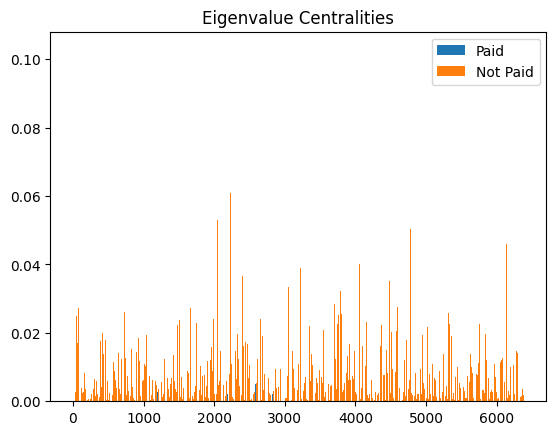

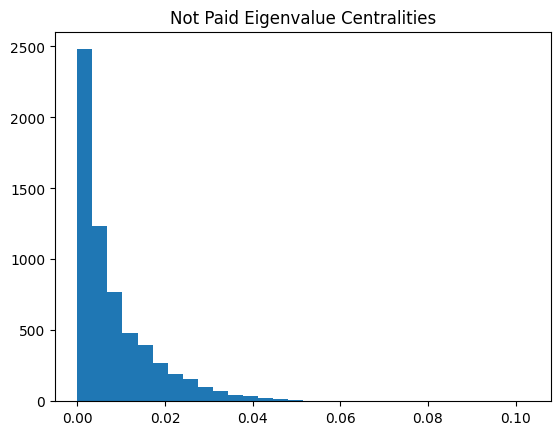

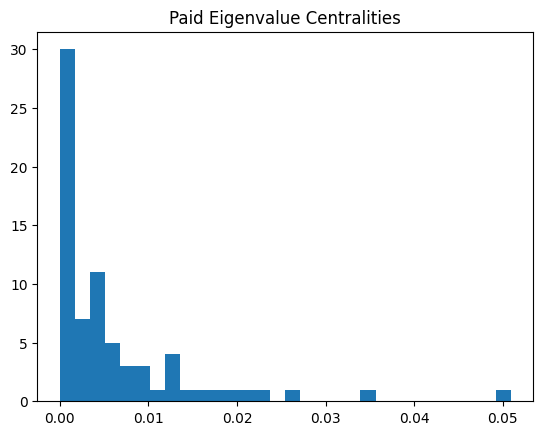

In [ ]:
# get the eigenvector centralities of the paid nodes
eig = nx.eigenvector_centrality_numpy(G_social)
eig = {k: v for k, v in sorted(eig.items(), key=lambda item: item[1], reverse=True)}
eig_paid = {k: v for k, v in eig.items() if k in pay_order}
eig_not_paid = {k: v for k, v in eig.items() if k not in pay_order}


plt.figure()
plt.bar(eig_paid.keys(), eig_paid.values())
plt.bar(eig_not_paid.keys(), eig_not_paid.values())
plt.legend(["Paid", "Not Paid"])
plt.title("Eigenvalue Centralities")
plt.show()

# make a histogram of the paid and not paid centralities
plt.figure()
plt.hist(eig_not_paid.values(), bins=30)
plt.title("Not Paid Eigenvalue Centralities")
plt.show()

plt.figure()
plt.hist(eig_paid.values(), bins=30)
plt.title("Paid Eigenvalue Centralities")
plt.show()


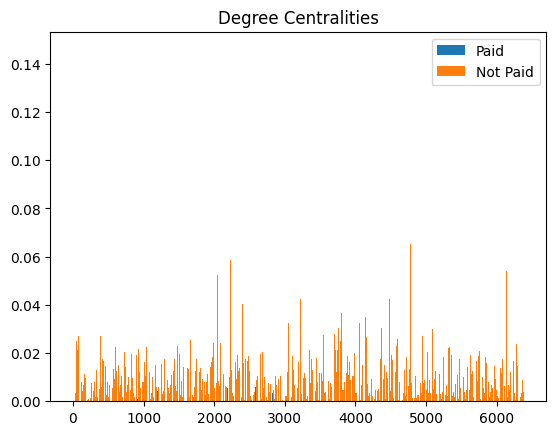

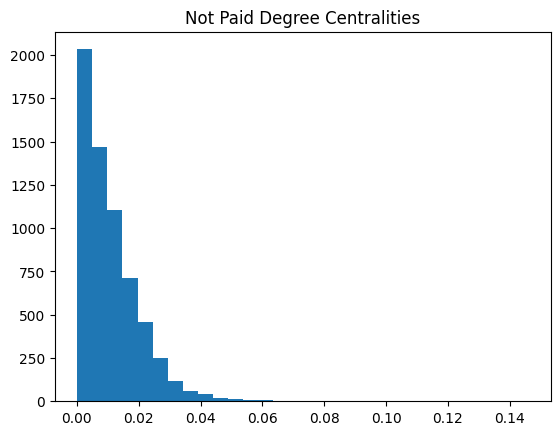

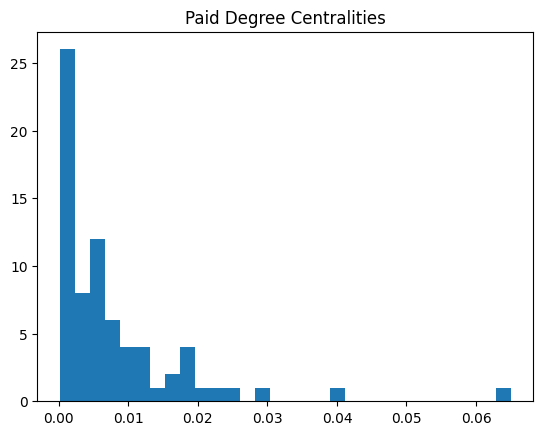

In [ ]:
# get the degree centralities of the paid nodes
deg = nx.degree_centrality(G_social)
deg = {k: v for k, v in sorted(deg.items(), key=lambda item: item[1], reverse=True)}
deg_paid = {k: v for k, v in deg.items() if k in pay_order}
deg_not_paid = {k: v for k, v in deg.items() if k not in pay_order}

plt.figure()
plt.bar(deg_paid.keys(), deg_paid.values())
plt.bar(deg_not_paid.keys(), deg_not_paid.values())
plt.legend(["Paid", "Not Paid"])
plt.title("Degree Centralities")
plt.show()

# make a histogram of the paid and not paid centralities
plt.figure()
plt.hist(deg_not_paid.values(), bins=30)
plt.title("Not Paid Degree Centralities")
plt.show()

plt.figure()
plt.hist(deg_paid.values(), bins=30)
plt.title("Paid Degree Centralities")
plt.show()
